<a href="https://colab.research.google.com/github/IsitaRex/Vibe-Sorcery/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vibe Sorcerer 🎼🔮  
**Summoning the perfect song for your mood, every time.**

Vibe Sorcerer is a mood-based playlist generator designed to create seamless, emotionally cohesive playlists. The core idea is simple: a great playlist isn’t just a random collection of songs—it’s a journey. By ensuring smooth transitions between tracks and maintaining a consistent emotional vibe, Vibe Sorcerer crafts playlists that feel intentional and immersive.


**Steps:**
1. Choose a song
2. Use MTG Listening Models to identify the most relevant moods of the song
3. Generate a caption of the song based on the mood
4. Generate a song based on the caption of the previous song
5. Repeat the process until you have your desired number of songs for the playlist

In [1]:
# !pip3 install essentia-tensorflow
# !pip3 install transformers
# !pip3 install diffusers
# !pip3 uninstall numpy -y
# !pip3 install numpy==1.26.4# Numpy < 2.0 needed for Essentia

## Step 1: Choose a song

In [7]:
#@markdown Upload the song into the same folder of this notebook and save it as "input_song.wav". Alternatively, modify the name of input_song variable
import librosa
import librosa.display
import IPython.display as ipd

audio_path = 'input_song.wav'
audio_data, sample_rate = librosa.load(audio_path)

ipd.Audio(audio_data, rate=sample_rate)


## Step 2: Use MTG Listening Models to identify the most relevant moods of the song

In [ ]:
#@title Load the MTG Listening Models
# Essentia for tagging the music

from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
!wget https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.pb
!wget https://essentia.upf.edu/models/classification-heads/mtg_jamendo_moodtheme/mtg_jamendo_moodtheme-discogs-effnet-1.pb

embeddings_model = TensorflowPredictEffnetDiscogs(
    graphFilename="discogs-effnet-bs64-1.pb",
    output="PartitionedCall:1",
)

mood_classification_model = TensorflowPredict2D(
    graphFilename="mtg_jamendo_moodtheme-discogs-effnet-1.pb",
    output='model/Sigmoid',
)


--2025-04-21 14:10:17--  https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.pb
Resolving essentia.upf.edu (essentia.upf.edu)... 84.89.139.43
Connecting to essentia.upf.edu (essentia.upf.edu)|84.89.139.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18366619 (18M) [application/octet-stream]
Saving to: ‘discogs-effnet-bs64-1.pb’

discogs-effnet-bs64 100%[===================>]  17.52M   845KB/s    in 21s     

2025-04-21 14:10:39 (847 KB/s) - ‘discogs-effnet-bs64-1.pb’ saved [18366619/18366619]

--2025-04-21 14:10:39--  https://essentia.upf.edu/models/classification-heads/mtg_jamendo_moodtheme/mtg_jamendo_moodtheme-discogs-effnet-1.pb
Resolving essentia.upf.edu (essentia.upf.edu)... 84.89.139.43
Connecting to essentia.upf.edu (essentia.upf.edu)|84.89.139.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2739668 (2.6M) [application/octet-stream]
Saving to: ‘mtg_jamendo_moodtheme-discogs-eff

https://huggingface.co/riffusion/riffusion-model-v1

In [ ]:
#@title Functions for Using the Listening Models

mood_tags = [
  "action", "adventure", "advertising", "background", "ballad", "calm",
  "children", "christmas", "commercial", "cool", "corporate",
  "dark", "deep", "documentary", "drama", "dramatic",
  "dream", "emotional", "energetic", "epic", "fast",
  "film", "fun", "funny", "game", "groovy",
  "happy", "heavy", "holiday", "hopeful", "inspiring",
  "love", "meditative", "melancholic", "melodic", "motivational",
  "movie", "nature", "party", "positive", "powerful",
  "relaxing", "retro", "romantic", "sad", "sexy",
  "slow", "soft", "soundscape", "space", "sport",
  "summer", "trailer", "travel", "upbeat", "uplifting"
]

def get_mood_activations_dict(wav_filepath):
  audio = MonoLoader(filename=wav_filepath, sampleRate=32000)()
  embeddings = embeddings_model(audio)
  activations = mood_classification_model(embeddings)
  activation_avs = []
  for i in range(0, len(activations[0])):
    vals = [activations[j][i] for j in range(0, len(activations))]
    # Note - this does the averaging bit
    activation_avs.append(sum(vals)/len(vals))
  activations_dict = {}
  for ind, tag in enumerate(mood_tags):
    activations_dict[tag] = activation_avs[ind]
  return activations_dict

In [ ]:
def get_top_k_moods(mood_dict, k=5):
    """
    Returns the top k moods from a mood dictionary.

    Args:
        mood_dict (dict): A dictionary mapping mood tags to activation values.
        k (int, optional): The number of top moods to return. Defaults to 5.

    Returns:
        list: A list of the top k moods.
    """

    # Sort the mood dictionary by activation values in descending order
    sorted_moods = sorted(mood_dict.items(), key=lambda item: item[1], reverse=True)

    # Return the top k moods
    return [mood[0] for mood in sorted_moods[:k]]

In [ ]:
mood_dict = get_mood_activations_dict(audio_path)

In [ ]:
top_moods = get_top_k_moods(mood_dict, k = 5)
print('The moods of the song were:', top_moods)

The moods of the song were: ['dark', 'energetic', 'melodic', 'love', 'slow']


## Step 3: Generate a caption of the song based on the mood

By leveraging the moods identified by the MTG listening models, we can generate captions that effectively describe the emotional essence of a song. To achieve this, we employ grammatical structures and patterns. Grammars are utilized for this purpose because they provide a flexible and adaptable framework for constructing meaningful and diverse captions.

While language models could be employed for caption generation, grammars offer distinct advantages. They provide greater control over the structure, length, and content of the captions, mitigating the risk of irrelevant or nonsensical outputs (hallucinations). However, it's worth noting that while grammars themselves offer this control, the initial templates for these grammars were, in fact, generated using large language models (LLMs) such as DeepSeek, leveraging their creative potential while retaining the benefits of grammar-based generation.

In [ ]:
import random
from collections import defaultdict

# Mood tags and their synonyms/related terms
mood_synonyms = {
    "action": ["intense", "thrilling", "dynamic", "explosive", "pumping"],
    "adventure": ["exploratory", "journey", "quest", "expedition", "voyage"],
    "advertising": ["promotional", "catchy", "jingle", "branded", "commercial"],
    "background": ["ambient", "subtle", "unobtrusive", "atmospheric", "underscore"],
    "ballad": ["storytelling", "narrative", "emotional", "heartfelt", "intimate"],
    "calm": ["peaceful", "serene", "tranquil", "soothing", "gentle"],
    "children": ["playful", "whimsical", "innocent", "youthful", "fun"],
    "christmas": ["festive", "holiday", "cheerful", "jolly", "wintry"],
    "commercial": ["catchy", "memorable", "upbeat", "positive", "energetic"],
    "cool": ["chill", "laid-back", "smooth", "relaxed", "mellow"],
    "corporate": ["professional", "polished", "refined", "sleek", "business"],
    "dark": ["brooding", "ominous", "mysterious", "gloomy", "shadowy"],
    "deep": ["profound", "thoughtful", "philosophical", "introspective", "meaningful"],
    "documentary": ["informative", "educational", "factual", "realistic", "authentic"],
    "drama": ["theatrical", "expressive", "passionate", "intense", "serious"],
    "dramatic": ["theatrical", "grand", "powerful", "stirring", "emotive"],
    "dream": ["ethereal", "surreal", "fantastical", "otherworldly", "floaty"],
    "emotional": ["feeling", "sentimental", "expressive", "touching", "moving"],
    "energetic": ["lively", "vibrant", "animated", "spirited", "exuberant"],
    "epic": ["grandiose", "majestic", "heroic", "monumental", "cinematic"],
    "fast": ["rapid", "quick", "speedy", "brisk", "up-tempo"],
    "film": ["cinematic", "soundtrack", "orchestral", "visual", "thematic"],
    "fun": ["playful", "joyful", "lighthearted", "cheerful", "amusing"],
    "funny": ["humorous", "comical", "witty", "silly", "laughable"],
    "game": ["interactive", "playful", "competitive", "immersive", "virtual"],
    "groovy": ["funky", "rhythmic", "danceable", "syncopated", "boogie"],
    "happy": ["joyful", "cheerful", "upbeat", "sunny", "positive"],
    "heavy": ["intense", "powerful", "weighty", "forceful", "aggressive"],
    "holiday": ["festive", "celebratory", "seasonal", "vacation", "cheerful"],
    "hopeful": ["optimistic", "promising", "encouraging", "bright", "positive"],
    "inspiring": ["motivational", "uplifting", "encouraging", "stimulating", "empowering"],
    "love": ["romantic", "affectionate", "passionate", "tender", "intimate"],
    "meditative": ["contemplative", "reflective", "zen", "calm", "peaceful"],
    "melancholic": ["nostalgic", "wistful", "bittersweet", "pensive", "sorrowful"],
    "melodic": ["tuneful", "harmonious", "musical", "lyrical", "catchy"],
    "motivational": ["inspirational", "encouraging", "empowering", "rousing", "stimulating"],
    "movie": ["cinematic", "filmic", "theatrical", "dramatic", "narrative"],
    "nature": ["organic", "natural", "earthy", "outdoors", "environmental"],
    "party": ["festive", "celebratory", "lively", "fun", "social"],
    "positive": ["optimistic", "upbeat", "cheerful", "happy", "bright"],
    "powerful": ["strong", "forceful", "intense", "potent", "dynamic"],
    "relaxing": ["calming", "soothing", "peaceful", "restful", "tranquil"],
    "retro": ["vintage", "nostalgic", "classic", "old-school", "throwback"],
    "romantic": ["loving", "passionate", "intimate", "affectionate", "sentimental"],
    "sad": ["mournful", "sorrowful", "melancholy", "blue", "heartbreaking"],
    "sexy": ["sensual", "seductive", "alluring", "provocative", "flirtatious"],
    "slow": ["leisurely", "unhurried", "measured", "languid", "deliberate"],
    "soft": ["gentle", "quiet", "delicate", "muted", "subtle"],
    "soundscape": ["textural", "environmental", "immersive", "atmospheric", "ambient"],
    "space": ["cosmic", "stellar", "astral", "celestial", "interstellar"],
    "sport": ["athletic", "energetic", "competitive", "dynamic", "active"],
    "summer": ["sunny", "warm", "bright", "carefree", "vacation"],
    "trailer": ["teaser", "promotional", "cinematic", "dramatic", "epic"],
    "travel": ["wanderlust", "exploration", "journey", "adventure", "movement"],
    "upbeat": ["cheerful", "lively", "positive", "energetic", "bouncy"],
    "uplifting": ["inspiring", "encouraging", "heartening", "positive", "elevating"]
}

# Grammar templates for different types of captions
grammar_templates = [
    # Simple descriptor patterns
    ["This is a", "{mood}", "song"],
    ["A", "{mood}", "tune for your", "{mood}", "moments"],
    ["Feeling", "{mood}", "? This track captures that vibe"],
    ["The perfect", "{mood}", "soundtrack for your day"],

    # Comparative patterns
    ["Like", "{mood}", "meets", "{mood}", "in this melodic journey"],
    ["A blend of", "{mood}", "and", "{mood}", "vibes"],
    ["More", "{mood}", "than a", "{mood}", "sunset"],

    # Action-oriented patterns
    ["Let this", "{mood}", "beat lift your spirits"],
    ["Dance to the", "{mood}", "rhythm of this track"],
    ["Get lost in the", "{mood}", "melodies"],

    # Descriptive patterns
    ["A", "{mood}", "composition with", "{mood}", "undertones"],
    ["Full of", "{mood}", "energy and", "{mood}", "harmonies"],
    ["A", "{mood}", "soundscape that feels", "{mood}"],

    # Emotional patterns
    ["When you need something", "{mood}", "and", "{mood}"],
    ["For those", "{mood}", "nights and", "{mood}", "days"],
    ["Music to feel", "{mood}", "and", "{mood}"]
]

class SongCaptionGenerator:
    def __init__(self, mood_tags, mood_synonyms, grammar_templates):
        self.mood_tags = mood_tags
        self.mood_synonyms = mood_synonyms
        self.grammar_templates = grammar_templates

    def get_synonym(self, mood):
        """Get a random synonym for the given mood"""
        synonyms = self.mood_synonyms.get(mood, [mood])
        return random.choice(synonyms)

    def generate_caption(self, primary_mood, secondary_mood=None):
        """Generate a song caption based on moods"""
        # Select a random template
        template = random.choice(self.grammar_templates)

        # Process each part of the template
        caption_parts = []
        for part in template:
            if part == "{mood}":
                # Alternate between primary and secondary mood if available
                if secondary_mood and random.random() > 0.6:
                    use_mood = secondary_mood
                else:
                    use_mood = primary_mood

                # Use the base mood or a synonym
                if random.random() > 0.5:
                    caption_parts.append(self.get_synonym(use_mood))
                else:
                    caption_parts.append(use_mood)
            else:
                caption_parts.append(part)

        # Join the parts and capitalize first letter
        caption = " ".join(caption_parts)
        return caption[0].upper() + caption[1:]

    def generate_captions(self, primary_mood, secondary_mood=None, count=5):
        """Generate multiple unique captions"""
        captions = set()
        while len(captions) < count:
            captions.add(self.generate_caption(primary_mood, secondary_mood))
            if len(captions) >= 10:  # Prevent infinite loops
                break
        return list(captions)

Now we are going to generate a caption based on the top 2 mood_tags of the song

In [ ]:
generator = SongCaptionGenerator(mood_tags, mood_synonyms, grammar_templates)
print(generator.generate_caption(top_moods[0], top_moods[1]))

A ominous composition with animated undertones


## Step 4: Generate a song based on the caption of the previous song

To generate the next song in the playlist, we are going to use Riffussion, a generative model that takes descriptions of songs as input and then produces the spectrogram, which can then be converted into a .wav file.

One of the hallmarks of Generative AI systems is the capacity to produce a vast number of variations from the same input, and this is a key aspect of Vibe Sorcerer. By reusing the caption generated for the current song as a prompt to generate a new song, slight variations introduced by the grammar and the generative music model ensure the playlist is both cohesive and diverse

In [2]:
# !pip install torchsde

In [10]:
# !huggingface-cli login

In [6]:
# import torch
# import soundfile as sf
# from diffusers import StableAudioPipeline

# pipe = StableAudioPipeline.from_pretrained("stabilityai/stable-audio-open-1.0", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [11]:
# # define the prompts
# prompt = "A dark song with animated undertones"
# negative_prompt = "Low quality."

# # set the seed for generator
# generator = torch.Generator("cuda").manual_seed(0)

# # run the generation
# audio = pipe(
#     prompt,
#     negative_prompt=negative_prompt,
#     num_inference_steps=200,
#     audio_end_in_s=47.0,
#     num_waveforms_per_prompt=3,
#     generator=generator,
# ).audios

# output = audio[0].T.float().cpu().numpy()
# sf.write("hammer.wav", output, pipe.vae.sampling_rate)


In [ ]:
from diffusers import DiffusionPipeline

In [ ]:
pipeline = DiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1")

In [ ]:
# Define your prompt
prompt = "A cheerful and upbeat melody with a tropical vibe"

# Generate the audio
# audio = pipeline(prompt=prompt)

In [ ]:
audio

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7A1A28B9C810>], nsfw_content_detected=[False])

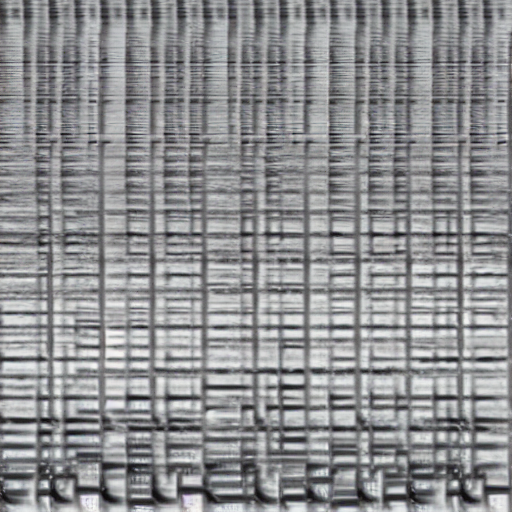

In [ ]:
audio["images"][0]

In [ ]:
type(audio["images"][0])

PIL.Image.Image

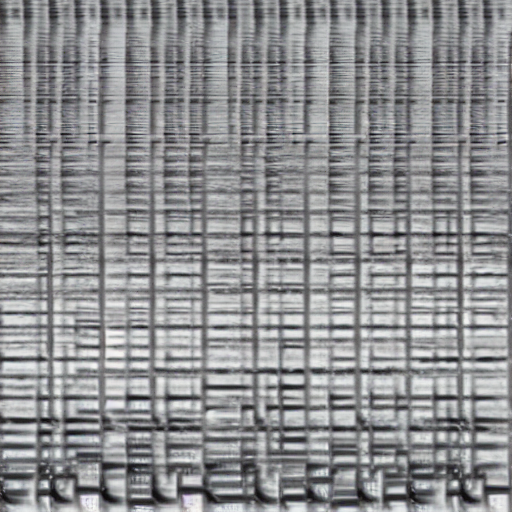

In [ ]:
audio["images"][0]

In [ ]:
img = audio["images"][0]

In [ ]:
 audio["images"][0]

SyntaxError: invalid decimal literal (<ipython-input-98-da88501820fd>, line 3)

In [ ]:
import io
import typing as T
import numpy as np
from PIL import Image
from scipy.io import wavfile
import librosa

def spectrogram_from_image(
        image: Image.Image,
        max_volume: float = 50,
        power_for_image: float = 0.25
) -> np.ndarray:
    """
    Compute a spectrogram magnitude array from a spectrogram image.
    """
    # Convert to a numpy array of floats
    data = np.array(image).astype(np.float32)
    # Flip Y take a single channel
    if len(data.shape) < 3:
        data = data[::-1]
    else:
        data = data[::-1, :, 0]
    # Invert
    data = 255 - data
    # Rescale to max volume
    data = data * max_volume / 255
    # Reverse the power curve
    data = np.power(data, 1 / power_for_image)
    return data

def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft: int,
    hop_length: int,
    win_length: int,
    num_samples: int,
    sample_rate: int,
    mel_scale: bool = True,
    n_mels: int = 512,
    num_griffin_lim_iters: int = 32,
) -> np.ndarray:
    """
    Reconstruct a waveform from a spectrogram using librosa.
    """
    if mel_scale:
        # Convert mel spectrogram back to linear STFT
        Sxx = librosa.feature.inverse.mel_to_stft(
            Sxx,
            sr=sample_rate,
            n_fft=n_fft,
            power=1.0,
        )

    # Griffin-Lim algorithm to reconstruct the waveform
    waveform = librosa.griffinlim(
        Sxx,
        n_iter=num_griffin_lim_iters,
        hop_length=hop_length,
        win_length=win_length,
        n_fft=n_fft,
    )

    return waveform

def wav_bytes_from_spectrogram_image(
    image: Image.Image,
    duration: int,
    nmels: int,
    maxvol: int,
    power_for_image: float,
) -> T.Tuple[io.BytesIO, float]:
    """
    Reconstruct a WAV audio clip from a spectrogram image. Also returns the duration in seconds.
    """
    max_volume = maxvol
    Sxx = spectrogram_from_image(image, max_volume=max_volume, power_for_image=power_for_image)

    sample_rate = 44100  # [Hz]
    clip_duration_ms = duration  # [ms]

    bins_per_image = 512
    n_mels = nmels

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(image.width / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    samples = waveform_from_spectrogram(
        Sxx=Sxx,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        num_samples=num_samples,
        sample_rate=sample_rate,
        mel_scale=True,
        n_mels=n_mels,
        num_griffin_lim_iters=32,
    )

    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples.astype(np.int16))
    wav_bytes.seek(0)

    duration_s = float(len(samples)) / sample_rate

    return wav_bytes, duration_s

def write_bytesio_to_file(filename, bytesio):
    """
    Write the contents of the given BytesIO to a file.
    Creates the file or overwrites the file if it does
    not exist yet.
    """
    with open(filename, "wb") as outfile:
        # Copy the BytesIO stream to the output file
        outfile.write(bytesio.getbuffer())

In [ ]:
# Load a spectrogram image
image = img

# Generate WAV bytes and duration
wav_bytes, duration_s = wav_bytes_from_spectrogram_image(
    image,
    duration=5000,  # 5 seconds
    nmels=512,
    maxvol=50,
    power_for_image=0.25,
)

# Save the WAV file
write_bytesio_to_file("output.wav", wav_bytes)

print(f"Audio saved as 'output.wav' with duration {duration_s:.2f} seconds")